# DATASET

In [7]:
import numpy as np
import tensorflow_datasets as tfds
import tqdm
from PIL import Image
from IPython import display

import mujoco,sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../package/')
sys.path.append('../package/helper/')
sys.path.append('../package/mujoco_usage/')

from mujoco_parser import *
from transformation import *
from slider import *
from utility import *
from utils import *

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo:[%s]"%(mujoco.__version__))

MuJoCo:[3.1.6]


In [8]:
dataset = DATASETS[35] # kaist_nonprehensile_converted_externally_to_rlds
display_key = 'image'

ds, iterator = get_dataset(dataset, display_key=display_key)

FeaturesDict({
    'episode_metadata': FeaturesDict({
        'file_path': Text(shape=(), dtype=string),
    }),
    'steps': Dataset({
        'action': Tensor(shape=(20,), dtype=float32),
        'discount': Scalar(shape=(), dtype=float32),
        'is_first': bool,
        'is_last': bool,
        'is_terminal': bool,
        'language_embedding': Tensor(shape=(512,), dtype=float32),
        'language_instruction': Text(shape=(), dtype=string),
        'observation': FeaturesDict({
            'image': Image(shape=(480, 640, 3), dtype=uint8),
            'partial_pointcloud': Tensor(shape=(512, 3), dtype=float32),
            'state': Tensor(shape=(21,), dtype=float32),
        }),
        'reward': Scalar(shape=(), dtype=float32),
    }),
})


In [9]:
episode = next(iterator)
images = get_image_from_episode(episode, display_key=display_key)

import os
from PIL import Image
import numpy as np
os.environ["IMAGEIO_FFMPEG_EXE"] = "/opt/homebrew/bin/ffmpeg"

from moviepy import *

frames = [np.array(img.convert('RGB')) for img in images]
clip = ImageSequenceClip(frames, fps=3)
clip.write_videofile("output.mp4", codec='libx264', audio=False)

2025-01-29 17:30:35.671177: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-01-29 17:30:49.852435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:6: Filling up shuffle buffer (this may take a while): 2 of 10
2025-01-29 17:30:51.011351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-01-29 17:30:51.112260: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


MoviePy - Building video output.mp4.
MoviePy - Writing video output.mp4



MoviePy - Done !
MoviePy - video ready output.mp4


In [10]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def arr2image(array):
    """
    Displays a NumPy array (h, w, c) as an image.
    """
    # Check the array shape and type
    if len(array.shape) != 3 or array.shape[2] not in [3, 4]:
        raise ValueError("Input array must have shape (h, w, c) with c=3 (RGB) or c=4 (RGBA).")
    
    # Display the image using matplotlib
    plt.imshow(array)
    plt.axis('off')  # Turn off axis
    plt.show()

# EPISODE

In [23]:
iter_steps = iter(episode['steps'])
eef_states = [eef['observation']['state'][-7:] for eef in iter_steps]

iter_steps = iter(episode['steps'])
joint_states = [joint['observation']['state'][:7] for joint in iter_steps]

iter_steps = iter(episode['steps'])
actions = [action['action'] for action in iter_steps]

# ENV

In [24]:
xml_path = '../mujoco_menagerie/franka_emika_panda/mjx_scene.xml'
env = MuJoCoParserClass(name='Tabletop',rel_xml_path=xml_path,verbose=False)

# CONTROL

In [13]:
# Visualize environment with initial pose from trajectory
env.init_viewer(
    title='Tabletop',
    transparent=False,
    azimuth=133,
    distance=3.5,
    elevation=-42.4,
    lookat=(-0.06,0.07,0.31),
)

joint_names = env.joint_names[:-2]
q0 = np.zeros(len(joint_names), dtype=float)

env.reset()
env.forward(q=q0, joint_names=joint_names)

while env.is_viewer_alive():
  env.step()
  if env.loop_every(tick_every=10):
    env.plot_T(
        T=env.get_T_body(body_name='link0'),
        axis_len=0.5,print_xyz=False)
    
    env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
    env.plot_contact_info(
        r_arrow=0.005,h_arrow=0.1,rgba_contact=(1,0,0,0.5),plot_sphere=False)
    
    env.render()

env.close_viewer()

In [8]:
sliders = MultiSliderClass( # Slider for EE control
    n_slider      = 7,
    title         = 'Sliders for [%s] Control'%(env.name),
    window_width  = 450,
    window_height = 300,
    x_offset      = 0,
    y_offset      = 100,
    slider_width  = 300,
    label_texts   = ['X','Y','Z','Roll-deg','Pitch-deg','Yaw-deg','Gripper'],
    slider_mins   = [-1,-1,-1,-180,-180,-180,0],
    slider_maxs   = [+1,+1,+1,+180,+180,+180,255],
    slider_vals   = [0,0,0,0,0,0,0],
    resolutions   = [0.02,0.02,0.02,3.6,3.6,3.6,0.04], # range/50
    verbose       = False,
)

joint_names = env.joint_names[:-2]

# q0 = np.zeros(len(joint_names), dtype=float)
q0 = np.deg2rad([0.0, 0.0, 0.0, -90.0, 0.0, 90.0, 0.0])
# q0 = q_traj[60]

env.init_viewer(
    title       = 'Tabletop',
    transparent = False,
    azimuth     = 133,
    distance    = 3.5,
    elevation   = -42.4,
    lookat      = (-0.06,0.07,0.31),
)

env.reset() # reset
env.forward(q=q0,joint_names=joint_names) # initial position

p0 = env.get_p_body(body_name='tcp_link')
R0 = env.get_R_body(body_name='tcp_link')

# Loop
q_ik_init = q0.copy()
while env.is_viewer_alive():
    
    # Update
    sliders.update() # update slider
    xyzrpyg = sliders.get_slider_values()
    qpos,ik_err_stack,ik_info = solve_ik(
        env                = env,
        joint_names_for_ik = joint_names,
        body_name_trgt     = 'tcp_link',
        q_init             = q_ik_init,
        p_trgt             = xyzrpyg[:3]+p0,
        R_trgt             = rpy_deg2r(xyzrpyg[3:6])@R0,
        max_ik_tick        = 500,
        ik_stepsize        = 1.0,
        ik_eps             = 1e-2,
        ik_th              = np.radians(5.0),
        render             = False,
        verbose_warning    = False,
    )
    ik_err = np.abs(ik_err_stack).max() # IK error
    if ik_err < 1e-2: q_ik_init = qpos.copy()
    else: q_ik_init = q0.copy()
    
    env.step( # dynamic update
        ctrl        = qpos, #np.append(np.append(qpos,xyzrpyg[6]),xyzrpyg[6]),s
        joint_names = joint_names
    )
    
    # Render 
    if env.loop_every(tick_every=10):
        env.plot_T(
            T=env.get_T_body(body_name='link0'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='link0')+np.array([0,0,0.5]),
            label = 'time:[%.2f]sec ik_err:[%.3f]'%(env.get_sim_time(),ik_err))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        env.plot_contact_info(
            r_arrow=0.005,h_arrow=0.1,rgba_contact=(1,0,0,0.5),plot_sphere=False)
        plot_ik_info(env=env,ik_info=ik_info)
        
        env.render()

# Close
env.close_viewer()
sliders.close()
print ("Done.")

Done.


In [7]:
sliders = MultiSliderClass( # Slider for joint control
    n_slider      = 8,
    title         = 'Sliders for [%s] Control'%(env.name),
    window_width  = 450,
    window_height = 300,
    x_offset      = 0,
    y_offset      = 100,
    slider_width  = 300,
    label_texts   = ['Joint 1', 'Joint 2', 'Joint 3', 'Joint 4', 'Joint 5', 'Joint 6', 'Joint 7', 'gripper'],
    slider_mins   = np.degrees(env.joint_ranges[:-2,0]).tolist() + [0], # Convert joint ranges from radians to degrees
    slider_maxs   = np.degrees(env.joint_ranges[:-2,1]).tolist() + [0.04],
    slider_vals   = [0, 0, 0, 0, 0, 0, 0, 0],
    resolutions   = [(max-min)/50 for min,max in zip(np.degrees(env.joint_ranges[:,0]).tolist() + [0], 
                                                    np.degrees(env.joint_ranges[:,1]).tolist() + [0.04])],
    verbose       = False,
)

joint_names = env.joint_names[:-2]
q0 = np.zeros(len(joint_names), dtype=float)

env.init_viewer(
    title       = 'Tabletop',
    transparent = False,
    azimuth     = 133,
    distance    = 3.5,
    elevation   = -42.4,
    lookat      = (-0.06,0.07,0.31),
)
env.reset() # reset
env.forward(q=q0,joint_names=joint_names) # initial position

# Loop
while env.is_viewer_alive():
    
    # Update
    sliders.update() # update slider
    joint_values = sliders.get_slider_values()
    
    # Convert degrees to radians for joint angles
    qpos = np.radians(joint_values[:-1])
    
    env.step( # dynamic update
        ctrl        = qpos, # Last value is gripper
        joint_names = joint_names
    )
    
    # Render 
    if env.loop_every(tick_every=10):
        env.plot_T(
            T=env.get_T_body(body_name='link0'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='link0')+np.array([0,0,0.5]),
            label = 'time:[%.2f]sec'%(env.get_sim_time()))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        env.plot_contact_info(
            r_arrow=0.005,h_arrow=0.1,rgba_contact=(1,0,0,0.5),plot_sphere=False)
        
        env.render()

# Close
env.close_viewer()
sliders.close()
print ("Done.")

2025-01-24 21:28:26.602 python[21826:1314371] +[IMKClient subclass]: chose IMKClient_Modern
2025-01-24 21:28:26.602 python[21826:1314371] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Done.


2025-01-24 21:31:50.019 python[21826:1314371] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


# Trajectory

### 1) genration

In [25]:
joint_names = env.joint_names[:-2]

q0 = np.deg2rad([0.0, 0.0, 0.0, -90.0, 0.0, 90.0, 0.0])

q_traj = []

q_ik_init = q0.copy()
for ik_target in eef_states:
    # temp = quat2rpy(ik_target[3:].numpy())
    # rot_target = rpy2r(temp)

    qpos,ik_err_stack,ik_info = solve_ik(
        env                = env,
        joint_names_for_ik = joint_names,
        body_name_trgt     = 'tcp_link',
        q_init             = q_ik_init,
        p_trgt             = ik_target[:3],
        R_trgt             = quat2r(np.append(ik_target[-1], ik_target[-4:-1])),
        max_ik_tick        = 500,
        ik_stepsize        = 1.0,
        ik_eps             = 1e-2,
        ik_th              = np.radians(5.0),
        render             = False,
        verbose_warning    = False,
    )

    ik_err = np.abs(ik_err_stack).max() # IK error
    if ik_err < 1e-2: q_ik_init = qpos.copy()
    else: q_ik_init = q0.copy()
    
    # print(ik_err, ik_target[:3], rot_target)
    q_traj.append(qpos)

### 2) Comparing

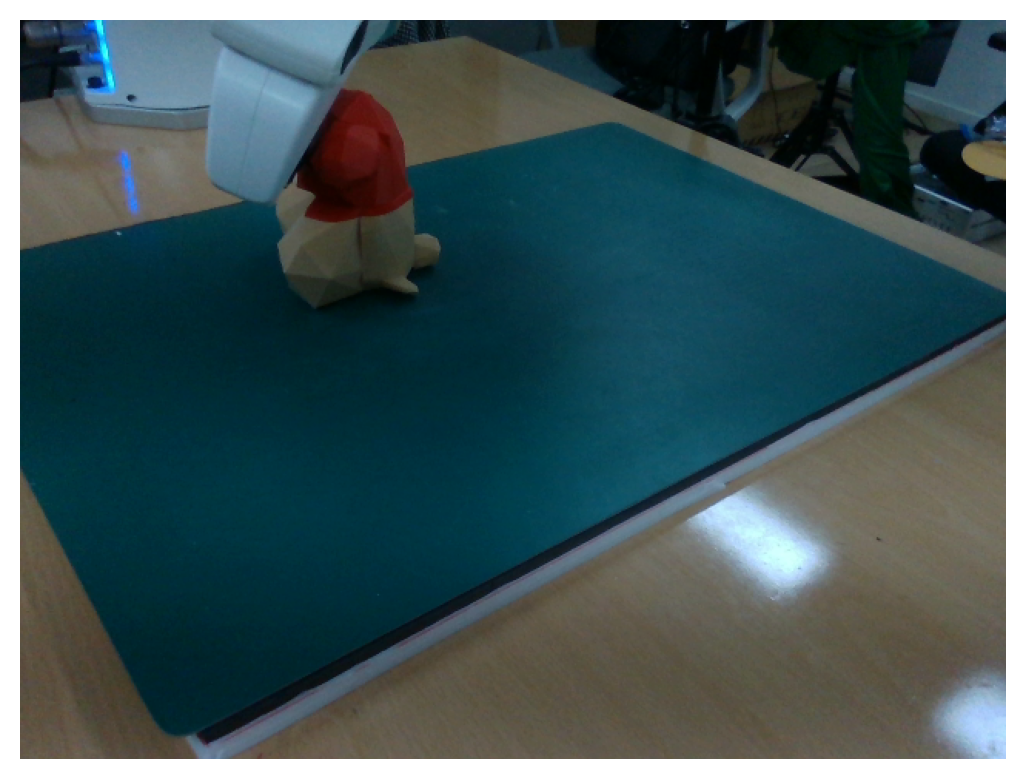

Done.


In [88]:
# G -> B -> R

idx =45
assert idx < len(frames)

sliders = MultiSliderClass( # Slider for EE control
    n_slider      = 7,
    title         = 'Sliders for [%s] Control'%(env.name),
    window_width  = 450,
    window_height = 300,
    x_offset      = 0,
    y_offset      = 100,
    slider_width  = 300,
    label_texts   = ['X','Y','Z','Roll-deg','Pitch-deg','Yaw-deg','Gripper'],
    slider_mins   = [-1,-1,0,-180,-180,-180,0],
    slider_maxs   = [+1,+1,1.2,+180,+180,+180,2],
    slider_vals   = [0,0,0,0,0,0,0],
    resolutions   = [0.02,0.02,0.02,3.6,3.6,3.6,0.04], # range/50
    verbose       = False,
)

joint_names = env.joint_names[:-2]

env.reset(step=True)

q0 = q_traj[idx]
env.forward(q=q0,joint_names=joint_names) # initial position

p0 = env.get_p_body(body_name='tcp_link')
R0 = env.get_R_body(body_name='tcp_link')

env.init_viewer(
    title       = 'Tabletop',
    transparent = False,
    azimuth     = 133,
    distance    = 3.5,
    elevation   = -42.4,
    lookat      = (-0.06,0.07,0.31),
)

arr2image(frames[idx])

# Loop
q_ik_init = q0.copy()
while env.is_viewer_alive():
    
    # Update
    sliders.update() # update slider
    xyzrpyg = sliders.get_slider_values()
    qpos,ik_err_stack,ik_info = solve_ik(
        env                = env,
        joint_names_for_ik = joint_names,
        body_name_trgt     = 'tcp_link',
        q_init             = q_ik_init,
        p_trgt             = xyzrpyg[:3]+p0,
        R_trgt             = rpy_deg2r(xyzrpyg[3:6])@R0,
        max_ik_tick        = 500,
        ik_stepsize        = 1.0,
        ik_eps             = 1e-2,
        ik_th              = np.radians(5.0),
        render             = False,
        verbose_warning    = False,
    )
    
    ik_err = np.abs(ik_err_stack).max() # IK error
    if ik_err < 1e-2: q_ik_init = qpos.copy()
    else: q_ik_init = q0.copy()
    
    env.step( # dynamic update
        ctrl        = qpos,
        joint_names = joint_names)
    
    # Render 
    if env.loop_every(tick_every=10):
        env.plot_T(
            T=env.get_T_body(body_name='link0'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='link0')+np.array([0,0,0.5]),
            label = 'time:[%.2f]sec ik_err:[%.3f]'%(env.get_sim_time(),ik_err))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        env.plot_contact_info(
            r_arrow=0.005,h_arrow=0.1,rgba_contact=(1,0,0,0.5),plot_sphere=False)
        plot_ik_info(env=env,ik_info=ik_info)
        
        env.render()

# Close
env.close_viewer()
sliders.close()
print("Done.")  

# Trajectory Reappearance

In [18]:
joint_names = env.joint_names[:-2]
q0 = np.deg2rad([0.0, 0.0, 0.0, -90.0, 0.0, 90.0, 0.0])

env.init_viewer(
    title       = 'Tabletop',
    transparent = False,
    azimuth     = 133,
    distance    = 3.5,
    elevation   = -42.4,
    lookat      = (-0.06,0.07,0.31),
)

env.reset() # reset
env.forward(q=q0,joint_names=joint_names) # initial position
    
# Loop
q_ik_init = q0.copy()
qpos = q_traj[0]
idx = 0

# append two gripper states to qpos
# gripper = gripper_states[0]
# qpos = np.append(qpos, [gripper, gripper])

while env.is_viewer_alive():
    env.forward(q=qpos,joint_names=joint_names)

    # Render 
    if env.loop_every(HZ=0.5):
        if idx < len(q_traj)-1:
            idx += 1
        else: idx = 0

        qpos = q_traj[idx]
        # gripper = gripper_states[idx]
        # qpos = np.append(qpos, [gripper, gripper])

        env.plot_T(
            T=env.get_T_body(body_name='link0'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='link0')+np.array([0,0,0.5]),
            label = 'tick:[%d]time:[%.2f]'%(idx, env.get_sim_time()))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        
        env.render()

# Close
env.close_viewer()
print ("Done.")

Done.


In [22]:
joint_names = env.joint_names[:-2]
q0 = np.zeros(len(joint_names), dtype=float)

env.init_viewer(
    title       = 'Tabletop',
    transparent = False,
    azimuth     = 133,
    distance    = 3.5,
    elevation   = -42.4,
    lookat      = (-0.06,0.07,0.31),
)

env.reset() # reset
env.forward(q=q0,joint_names=joint_names) # initial position
    
# Loop
q_ik_init = q0.copy()
qpos = joint_states[0]
idx = 0

while env.is_viewer_alive():
    env.forward(q=qpos,joint_names=joint_names)

    # Render 
    if env.loop_every(HZ=0.5):
        if idx == 10:
            print(env.get_p_body(body_name='tcp_link'))

        if idx < len(joint_states)-1:
            idx += 1
        else: idx = 0

        qpos = joint_states[idx]  # Use first 7 joints from joint_states

        env.plot_T(
            T=env.get_T_body(body_name='link0'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='link0')+np.array([0,0,0.5]),
            label = 'tick:[%d]time:[%.2f]'%(idx, env.get_sim_time()))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        
        env.render()

# Close
env.close_viewer()
print ("Done.")

# [ 0.46062913 -0.0419206   0.58133918] (calculated by joint_states) -> [0.46408984 -0.04164245  0.38942292] (EEF)
# [ 0.46334388 -0.04195479  0.57160527] (calculated by joint_states) -> [0.4666901  -0.04140665  0.37968513] (EEF)

[0.04513729 0.01913228 0.82593444]
[0.04513729 0.01913228 0.82593444]
Done.


# Reverse Engineering

In [89]:
# current link gripper -> tcp_link rpy 0,0,0
# target link gripper -> target rpy

target = np.append(states[idx][-3:], states[idx][-4])
target = quat2r(target)

base = env.get_R_body(body_name='hand')
current = env.get_R_body(body_name='tcp_link')

R = current.T@base
rpy = r2rpy(R)
print(rpy)

R = base.T@target
rpy = r2rpy(R)
# print(rpy)
print(rpy2quat(rpy))


'''
[-5.27306031e-17  9.32701387e-17  1.57079633e+00]
[ 1.48438446e-03  1.39833212e-01 -1.50792732e+00]
[ 0.72716463  0.04836099  0.05041956 -0.68289874]
[ 0.70710678  0.          0.         -0.70710678]


[9.99735615e-01 2.21498574e-02 9.10323765e-04 6.10366593e-03]
'''

[-3.11059253 -0.02384168 -2.67243978]
[0.09429042 0.54545434 0.7711033  0.31462451]


'\n[-5.27306031e-17  9.32701387e-17  1.57079633e+00]\n[ 1.48438446e-03  1.39833212e-01 -1.50792732e+00]\n[ 0.72716463  0.04836099  0.05041956 -0.68289874]\n[ 0.70710678  0.          0.         -0.70710678]\n\n\n[9.99735615e-01 2.21498574e-02 9.10323765e-04 6.10366593e-03]\n'

In [26]:
actions[0]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([ 2.0000000e-02,  5.8699795e-03, -2.2083265e-03, -1.7602876e-02,
        2.6542649e-02, -1.5206571e-02,  1.2992603e+02,  1.1182937e+02,
        1.5137903e+02,  1.4161649e+02,  9.7390305e+01,  9.3658966e+01,
        1.0000000e+01,  7.0489299e-01,  2.9999995e-01,  5.2964234e-01,
        4.7116470e-01,  2.9999995e-01,  2.9999995e-01,  1.6223261e+00],
      dtype=float32)>

In [28]:
i = 10

prev_xyz = eef_states[i-1][:3]
prev_rpy = quat2rpy(np.append(eef_states[i-1][4:], eef_states[i-1][3]))

real_nxt_xyz = eef_states[i][:3]
real_nxt_rpy = quat2rpy(np.append(eef_states[i][4:], eef_states[i][3]))

xyz_delta = actions[i-1][:3]
rpy_delta = actions[i-1][3:6]

alpha = 1
nxt_xyz = prev_xyz + xyz_delta * alpha
nxt_rpy = prev_rpy + rpy_delta * alpha

print("\nPrevious pose:")
print(f"XYZ:  {prev_xyz}")
print(f"RPY:  {prev_rpy}")

print("\nDelta:")
print(f"XYZ:  {xyz_delta}")
print(f"RPY:  {rpy_delta}")

print("\nPredicted next pose:")
print(f"XYZ:  {nxt_xyz}")
print(f"RPY:  {nxt_rpy}")

print("\nActual next pose:")
print(f"XYZ:  {real_nxt_xyz}")
print(f"RPY:  {real_nxt_rpy}")


Previous pose:
XYZ:  [0.47553918 0.05365673 0.12835297]
RPY:  [-0.16260022  0.13456946  2.25558227]

Delta:
XYZ:  [ 0.01832309  0.02       -0.0025928 ]
RPY:  [ 0.01671641 -0.01009863 -0.026561  ]

Predicted next pose:
XYZ:  [0.49386227 0.07365674 0.12576017]
RPY:  [-0.14588381  0.12447083  2.2290213 ]

Actual next pose:
XYZ:  [0.4815838  0.06074971 0.1212413 ]
RPY:  [-0.1776434   0.12997692  2.25965432]
